# Sensitivity analysis

In [1]:
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from h2ss import compare

In [2]:
cavern_diameter = np.arange(45, 106, step=5)
cavern_height = np.arange(80, 321, step=20)

In [3]:
def generate_sensitivity_data(diameter, height):
    """Generate data to perform sensitivity analysis"""
    os.makedirs(os.path.join("data", "sensitivity"), exist_ok=True)
    ds, extent, exclusions = compare.load_all_data()
    for d, h in product(diameter, height):
        filename = os.path.join(
            "data", "sensitivity", f"sensitivity_d{d}_h{h}.csv"
        )
        if not os.path.isfile(filename):
            df = compare.capacity_function(ds, extent, exclusions, d, h)
            df = df[["cavern_diameter", "cavern_height", "capacity"]]
            df.to_csv(filename)
            print(f"{filename} done!")
        else:
            print(f"{filename} exists!")

In [4]:
# generate_sensitivity_data(cavern_diameter, cavern_height)

In [5]:
filelist = []
for cd, ch in product(cavern_diameter, cavern_height):
    filelist.append(
        os.path.join("data", "sensitivity", f"sensitivity_d{cd}_h{ch}.csv")
    )

In [6]:
cdf = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

In [7]:
cdf.drop(columns=["Unnamed: 0"], inplace=True)

In [8]:
cdf["cavern_height"] = cdf["cavern_height"].astype(int)

In [9]:
cdf.describe()

,cavern_diameter,cavern_height,capacity
count,31780.00000,31780.000000,31780.000000
mean,64.28949,125.588420,71.731553
std,17.33300,51.088746,54.800259
min,45.00000,80.000000,10.663307
25%,50.00000,80.000000,34.958366
50%,60.00000,100.000000,55.633168
75%,75.00000,140.000000,89.563389
max,105.00000,320.000000,511.809957


In [10]:
# cavern height-to-diameter-ratio
pd.Series((cdf["cavern_height"] / cdf["cavern_diameter"]).unique()).describe()

count    130.000000
mean       2.908468
std        1.437914
min        0.761905
25%        1.783333
50%        2.701754
75%        3.685897
max        7.111111
dtype: float64

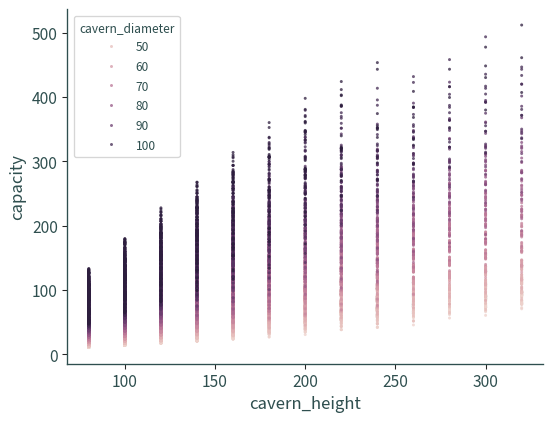

In [11]:
ax = sns.scatterplot(
    data=cdf,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_height",
    linewidth=0,
    alpha=0.75,
    s=5,
)
sns.despine()
plt.show()

In [12]:
len(cdf["cavern_diameter"].unique()) == len(cdf["cavern_height"].unique())

True

## Number of caverns and total capacity

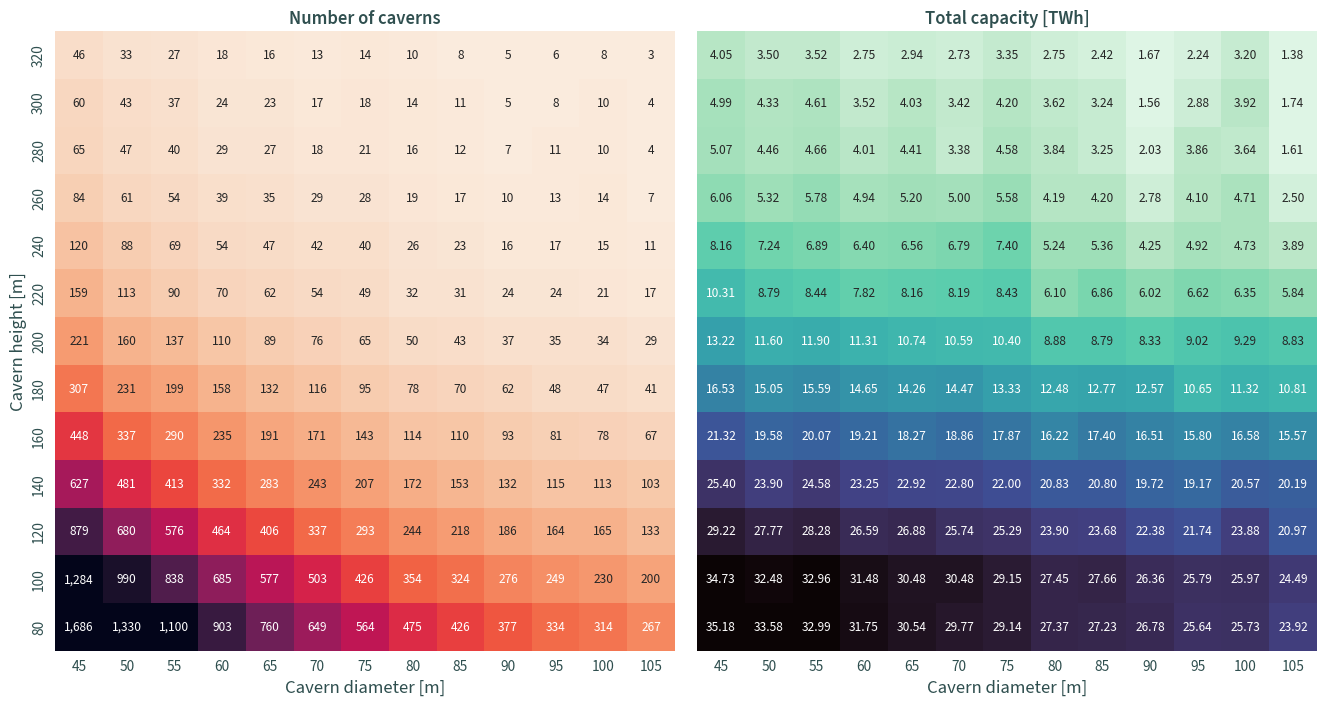

In [13]:
f, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

data = (
    cdf.groupby(["cavern_height", "cavern_diameter"])
    .count()
    .reset_index()
    .pivot(index="cavern_height", columns="cavern_diameter", values="capacity")
    .sort_index(ascending=False)
)
sns.heatmap(
    data,
    ax=ax[0],
    cmap="rocket_r",
    cbar=False,
    square=True,
    annot=True,
    fmt=",d",
    robust=True,
)

data = cdf.copy()
data["capacity"] = data["capacity"] / 1000
data = (
    data.groupby(["cavern_height", "cavern_diameter"])
    .sum()
    .reset_index()
    .pivot(index="cavern_height", columns="cavern_diameter", values="capacity")
    .sort_index(ascending=False)
)
sns.heatmap(
    data,
    ax=ax[1],
    cmap="mako_r",
    cbar=False,
    square=True,
    annot=True,
    robust=True,
    fmt=".2f",
)

for a in ax.flat:
    a.tick_params(axis="y", labelsize=11.5, left=False)
    a.tick_params(axis="x", labelsize=11.5, bottom=False)
    a.set_xlabel("Cavern diameter [m]")

ax[0].set_ylabel("Cavern height [m]")
ax[1].set_ylabel("")
ax[0].set_title("Number of caverns")
ax[1].set_title("Total capacity [TWh]")
plt.tight_layout()

# plt.savefig(
#     os.path.join("graphics", "fig_sensitivity_heatmap.jpg"),
#     format="jpg",
#     dpi=600,
# )
plt.show()

## Mean capacity

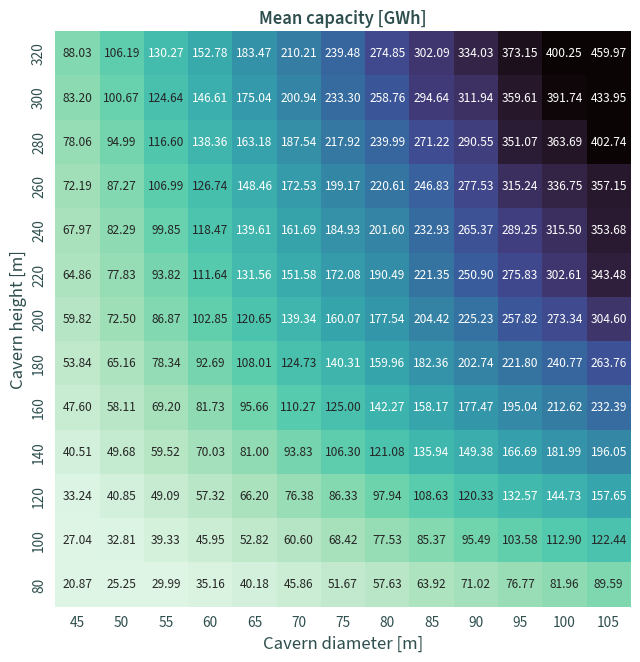

In [14]:
data = (
    cdf.groupby(["cavern_height", "cavern_diameter"])
    .mean()
    .reset_index()
    .pivot(index="cavern_height", columns="cavern_diameter", values="capacity")
    .sort_index(ascending=False)
)
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(
    data,
    ax=ax,
    cmap="mako_r",
    # cbar_kws={"label": "Mean capacity [GWh]"},
    cbar=False,
    square=True,
    annot=True,
    robust=True,
    fmt=".2f",
)
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Cavern height [m]")
ax.tick_params(axis="y", labelsize=11.5, left=False)
ax.tick_params(axis="x", labelsize=11.5, bottom=False)
plt.title("Mean capacity [GWh]")
# ax.plot(8.5, 10.5, "*", markersize=10, color="black")
plt.tight_layout()
plt.show()

## Base case

In [15]:
base = cdf[
    (cdf["cavern_diameter"] == 85) & (cdf["cavern_height"] == 120)
].reset_index(drop=True)

In [16]:
base.describe()[["capacity"]]

,capacity
count,218.000000
mean,108.634041
std,25.946851
min,55.946359
25%,89.482842
50%,109.211632
75%,129.493525
max,158.798899


In [17]:
base_mean = base[["capacity"]].mean().values[0]

In [18]:
base_sum = base[["capacity"]].sum().values[0]

In [19]:
base_count = base[["capacity"]].count().values[0]

In [20]:
print(f"{base_mean:.3f}")

108.634


In [21]:
print(f"{base_sum:.3f}")

23682.221


In [22]:
base_count

218

## Base diameter, varying height

In [23]:
dd = cdf[(cdf["cavern_diameter"] == 85)].reset_index(drop=True)

In [24]:
dd_mean = (
    pd.DataFrame(dd.groupby("cavern_height").mean()["capacity"] - base_mean)
    / base_mean
    * 100
).reset_index()

In [25]:
dd_sum = (
    pd.DataFrame(dd.groupby("cavern_height").sum()["capacity"] - base_sum)
    / base_sum
    * 100
).reset_index()

In [26]:
dd_count = (
    pd.DataFrame(dd.groupby("cavern_height").count()["capacity"] - base_count)
    / base_count
    * 100
).reset_index()

## Base height, varying diameter

In [27]:
dh = cdf[(cdf["cavern_height"] == 120)].reset_index(drop=True)

In [28]:
dh_mean = (
    pd.DataFrame(dh.groupby("cavern_diameter").mean()["capacity"] - base_mean)
    / base_mean
    * 100
).reset_index()

In [29]:
dh_sum = (
    pd.DataFrame(dh.groupby("cavern_diameter").sum()["capacity"] - base_sum)
    / base_sum
    * 100
).reset_index()

In [30]:
dh_count = (
    pd.DataFrame(
        dh.groupby("cavern_diameter").count()["capacity"] - base_count
    )
    / base_count
    * 100
).reset_index()

## Combined plots

In [31]:
dh_sum["type"] = "Total capacity"
dh_count["type"] = "Number of caverns"
dd_sum["type"] = "Total capacity"
dd_count["type"] = "Number of caverns"

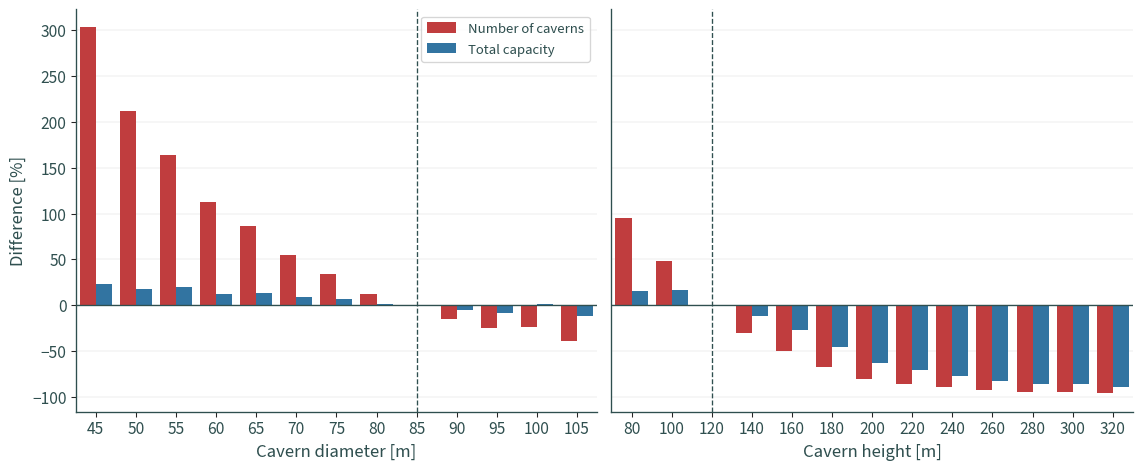

In [32]:
f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.barplot(
    data=pd.concat([dh_count, dh_sum]),
    hue="type",
    y="capacity",
    x="cavern_diameter",
    palette=sns.color_palette(["tab:red", "tab:blue"]),
    ax=ax[0],
)
sns.barplot(
    data=pd.concat([dd_count, dd_sum]),
    hue="type",
    y="capacity",
    x="cavern_height",
    palette=sns.color_palette(["tab:red", "tab:blue"]),
    legend=False,
    ax=ax[1],
)
for a in ax.flat:
    a.axhline(0, color="darkslategrey", linewidth=1)
    a.yaxis.grid(True, linewidth=0.25)
    # a.set(ylim=(-100, 200))
ax[0].axvline("85", color="darkslategrey", linewidth=1, linestyle="dashed")
ax[1].axvline("120", color="darkslategrey", linewidth=1, linestyle="dashed")
ax[0].set_xlabel("Cavern diameter [m]")
ax[1].set_xlabel("Cavern height [m]")
ax[0].set_ylabel("Difference [%]")
ax[1].legend(title=None, fontsize=11)
ax[1].tick_params(axis="y", left=False)

sns.despine()
plt.tight_layout()
# plt.savefig(
#     os.path.join("graphics", "fig_sensitivity.jpg"),
#     format="jpg",
#     dpi=600,
# )
plt.show()

In [33]:
def colour_label(data):
    "Use different colours for negative and positive values"
    conditions = [(data["capacity"] < 0), (data["capacity"] >= 0)]
    choices = ["N", "P"]
    data["colour"] = np.select(conditions, choices)
    return data

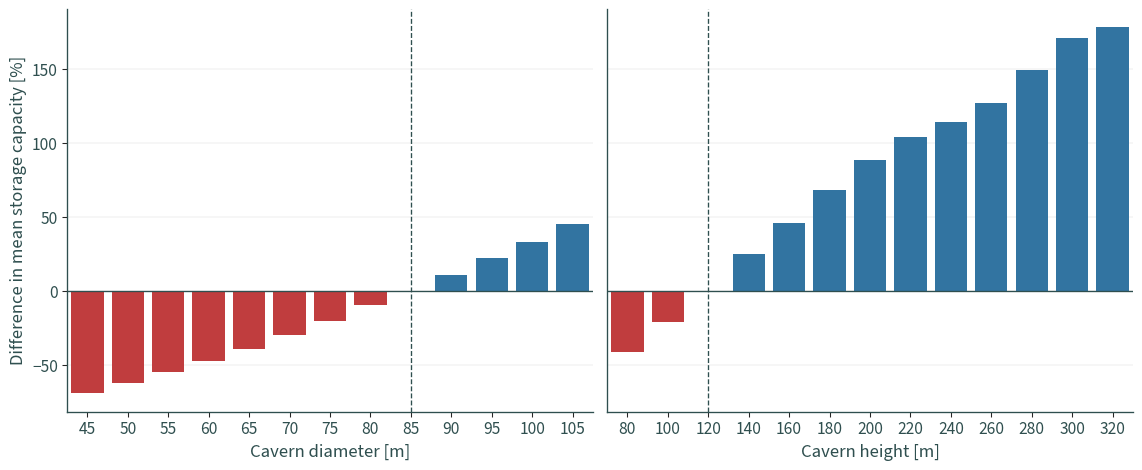

In [34]:
f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.barplot(
    data=colour_label(dh_mean),
    y="capacity",
    x="cavern_diameter",
    hue="colour",
    palette=sns.color_palette(["tab:red", "tab:blue"]),
    legend=False,
    ax=ax[0],
)
sns.barplot(
    data=colour_label(dd_mean),
    y="capacity",
    x="cavern_height",
    hue="colour",
    palette=sns.color_palette(["tab:red", "tab:blue"]),
    legend=False,
    ax=ax[1],
)

for a in ax.flat:
    a.axhline(0, color="darkslategrey", linewidth=1)
    a.yaxis.grid(True, linewidth=0.25)
ax[0].axvline("85", color="darkslategrey", linewidth=1, linestyle="dashed")
ax[1].axvline("120", color="darkslategrey", linewidth=1, linestyle="dashed")
ax[0].set_xlabel("Cavern diameter [m]")
ax[1].set_xlabel("Cavern height [m]")
ax[0].set_ylabel("Difference in mean storage capacity [%]")
ax[1].tick_params(axis="y", left=False)

sns.despine()
plt.tight_layout()
plt.show()